<a href="https://colab.research.google.com/github/arinaruck/DLA-2020/blob/master/dla_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework №3

This homework will be dedicated to Keyword Spotting (KWS), streaming and speedup NN.

# Data

In [1]:
import os
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./{}/{}".format(datadir, cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2020-11-06 18:52:38--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.12.240, 2607:f8b0:4004:807::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.12.240|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   216MB/s    in 6.3s    

2020-11-06 18:52:44 (227 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

mkdir: cannot create directory ‘speech_commands’: File exists
Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [2]:
!pip install wandb

In [3]:
keywords = ['marvin']

# Model

    In this homework assignment, you will need to implement a model for finding a keyword in a stream.

        1) https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf
            It is recommended to implement the version with CNN because it is easy and improves the model.

        2) What about streaming?
           This model works differently during training and inferance.
           During training you have some fixed input and you know that it has a keyword (or not).
           During the inferance, you read the T frames and make a prediction on them. And the next step is to read the T+1 frame,
           run the neural network just for it, and make a prediction based on it and the T-1 of the previous frames.
           This way you don't make unnecessary calculations.

           So, your model should support streaming mode.
           To demonstrate the work in streaming mode, take two random audio tracks of 10-20 seconds and glue them together
           so that your keyword will be between them. Run the model through this glued track and draw how the probability of your keyword changing over time.

        3) A good KWS is a robust KWS, so we ask you to implement as many augmentations as possible.
           (bonus) Download any noise from YouTube and add it as a background noise to the positive data. This helps a lot in real life.
           P.S. Use https://www.youtube-dl.org/

        4) (bonus) Add more attentions and orthogonality regularization. https://arxiv.org/abs/1910.04500
        
        5) (bonus) Speedup you model! Implement distillation of your model, for example,
            train the LSTM with 256 hidden size and distil it into LSTM with 128 hidden size.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!
    
    3) Good logging of experiments save your nerves and time, so we ask you to use W&B. Log loss, FA/FR rate or something else.
        Do not remove the logs until we have checked your work and given you a grade!
    
    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.
    
    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.
    
    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.

In [4]:
!pip install torchaudio

In [5]:
!ls speech_commands/six | wc -l

2369


In [6]:
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
import wandb
import torch
import torch.nn as nn
import torch.functional as F
import torchaudio
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader, WeightedRandomSampler
import os
from os.path import isdir, join
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import sys
import subprocess
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [8]:
from IPython import display as display_
wav, sr = torchaudio.load_wav('/content/speech_commands/_background_noise_/dude_miaowing.wav')
display_.display(display_.Audio(wav, rate=sr))
print(sr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: torchaudio.backend.sox_backend.load_wav has been deprecated and will be removed from 0.9.0 release. Please use "torchaudio.load".
  


16000


In [9]:
SR = 16000
N_MELS = 40
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
def pad_audio(samples, L):
    l = samples.shape[1]
    if l >= L: 
      return samples
    else: 
      return F.pad(samples, (0, L - l), 'constant', 0)

def chop_audio(samples, L):
    l = samples.shape[1]
    beg = torch.randint(high=l - L + 1, size=(1, 1))
    return samples[:, beg : beg + L]


def fix_size(samples, L):
    samples = pad_audio(samples, L)
    samples = chop_audio(samples, L)
    return samples

In [11]:
def transform(wav, noise):
    noise_level = torch.randint(0, 20, size=(1, 1))
    L = wav.shape[1]
    noise = fix_size(noise, L)
    noise_energy = torch.norm(noise)
    audio_energy = torch.norm(wav)
    alpha = (audio_energy / noise_energy) * torch.pow(10, -noise_level / 20)
    return wav + alpha * noise

class KeywordDataset(Dataset):
    def __init__(self, root, transform, transform_prob=0.5):
        super(KeywordDataset).__init__()
        noise_fldr = '_background_noise_'
        self.root = root
        class_id = lambda cls: int(cls == 'marvin')
        self.files = []
        self.targets = []
        for cls in os.listdir(root):
            if isdir(join(root, cls)) and cls != noise_fldr:
                for filename in os.listdir(join(root, cls)):
                    if filename[-3:] == 'wav':
                        self.files.append(join(cls, filename))
                        self.targets.append(class_id(cls))
        self.example_num = len(self.files)
        self.noises = []
        for filename in os.listdir(join(root, noise_fldr)):
            if filename[-3:] == 'wav':
                self.noises.append(join(noise_fldr, filename))
        self.transform = transform
        self.transform_prob = transform_prob
        
    def __getitem__(self, idx):
        filepath = os.path.join(self.root, self.files[idx])
        try:
            wav, sr = torchaudio.load(filepath)
        except:
            print(filepath)
        if self.transform is not None and np.random.rand() > self.transform_prob:
            noise = np.random.choice(self.noises)
            noise_wav, sr = torchaudio.load(join(self.root, noise))
            wav = self.transform(wav, noise_wav)
        wav = wav.squeeze()
        target = self.targets[idx]
        return wav, torch.Tensor([target]), wav.shape[0] / sr

    def __len__(self):
        return self.example_num

In [12]:
def make_datasets(root, transform, transform_prob=0.8):
    dataset = KeywordDataset(root, transform, transform_prob)
    idx = np.arange(len(dataset))
    targets = np.array(dataset.targets)
    train_idx, val_idx = train_test_split(idx, test_size=0.3, stratify=targets)
    val_idx, test_idx = train_test_split(val_idx, test_size=0.33, stratify=targets[val_idx])
    
    train_ds = Subset(dataset, train_idx)
    train_ds.targets = targets[train_idx]
    val_ds = Subset(dataset, val_idx)
    val_ds.targets = targets[val_idx]
    test_ds = Subset(dataset, test_idx)
    test_ds.targets = targets[test_idx]
    return train_ds, val_ds, test_ds

def collate_fn(batch):
    X, y, lens = zip(*batch)
    X = pad_sequence(X, batch_first=True)
    return X, torch.Tensor(y), torch.Tensor(lens)

def make_loader(dataset, bs):
    targets =  np.array(dataset.targets)
    pos = sum(targets)
    neg = len(targets) - pos
    weights = torch.Tensor([1 / pos if t == 1 else 1 / neg for t in targets])
    sampler = WeightedRandomSampler(weights, len(weights))
    loader = DataLoader(dataset, batch_size=bs, pin_memory=True, 
                              drop_last=False, sampler=sampler, collate_fn=collate_fn)
    return loader

def make_loaders(root, transform, transform_prob, batch_size):
    train_ds, val_ds, test_ds = make_datasets(root, transform, transform_prob)
    train_loader = make_loader(train_ds, batch_size)
    val_loader = make_loader(val_ds, batch_size)
    test_loader = make_loader(test_ds, batch_size)
    return train_loader, val_loader, test_loader

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio

from torchvision.transforms import Compose

#https://github.com/toshiks/number_recognizer/blob/master/app/dataset/preprocessing.py

class LogMelSpectrogram(nn.Module):
    """
    Create spectrogram from raw audio and make
    that logarithmic for avoiding inf values.
    """
    def __init__(self, sample_rate=16000, n_mels=40):
        super(LogMelSpectrogram, self).__init__()
        self.transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels,
                                                              n_fft=1024, hop_length=256,
                                                              f_min=0, f_max=8000)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spectrogram = self.transform(waveform)
        log_mel = torch.log(spectrogram + 1e-9)
        return (log_mel - log_mel.mean(dim=1, keepdim=True)) / \
            (log_mel.std(dim=1,keepdim=True) + 1e-9)


class MelAug(nn.Module):
    def __init__(self):
        super(MelAug, self).__init__()
        self.transforms = nn.Sequential(
            torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
            torchaudio.transforms.TimeMasking(time_mask_param=15)
        )

    def forward(self, melspec: torch.Tensor) -> torch.Tensor:
        return self.transforms(melspec)

class WavAug(nn.Module):
    def __init__(self):
        super(WavAug, self).__init__()

    def forward(self, wav):
        fade_const = 50
        fade = torch.randint(low=0, high=fade_const, size=(1,)).item()
        transform = nn.Sequential(
            torchaudio.transforms.Fade(fade, fade_const - fade),
        )
        return transform(wav)

In [15]:
class CRNN(nn.Module):
  def __init__(self, config):
    super(CRNN, self).__init__() 
    out_channels = config['out_channels']
    input_size = config['input_size']
    attn_size = config['attn_size']
    hidden_size = config['hidden_size']
    num_classes = config['num_classes']
    self.conv = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=1, 
                               kernel_size=(20, 1), stride=(8, 1)),
        nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(1, 5), stride=(1, 2)))
    self.gru = nn.GRU(input_size, hidden_size, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_size * 2, attn_size)
    self.relu = nn.ReLU()
    self.attn = nn.Sequential(
        nn.Linear(attn_size, attn_size),
        nn.Tanh(),
        nn.Linear(attn_size, 1, bias=False),
        nn.Softmax(dim=1)
    )
    self.out = nn.Linear(attn_size, num_classes, bias=False)

  def forward(self, x):
      x = x.unsqueeze(1)
      x = self.conv(x)
      batch_size, _, _, seq_len = x.shape
      x = x.view(batch_size, -1, seq_len).transpose(1, 2)
      x, _ = self.gru(x)
      x = self.fc(x)
      x = self.relu(x)
      attn_weights = self.attn(x)
      x = torch.bmm(attn_weights.transpose(1, 2), x)
      out = self.out(x)
      return out.squeeze(1)


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, checkpoint, patience=7, verbose=False, delta=0, min_loss=np.inf):
        """
        :param
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None if min_loss == np.inf else  -min_loss
        self.early_stop = False
        self.val_loss_min = min_loss
        self.delta = delta
        self.checkpoint = checkpoint

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss
            }, self.checkpoint)

        self.val_loss_min = val_loss

In [17]:
def train(epochs, model, optimizer, scheduler, device, early_stopping,
          train_loader, valid_loader=None, grad_acum=1, criterion=nn.BCEWithLogitsLoss()):
    process = nn.Sequential(
          LogMelSpectrogram(SR, N_MELS).to(device),
          MelAug().to(device)
    )
    clip = 15
    for epoch in range(epochs):
        optimizer.zero_grad()
        tr_loss, val_loss = 0, 0
        tr_steps, val_steps = 0, 0
        all_preds = torch.tensor([])
        all_labels = torch.tensor([])
        all_lens = torch.tensor([])
        for X, y, lens in tqdm(train_loader):
            model.train()
            y = y.to(device, non_blocking=True)
            X = process(X.to(device))
            preds = model(X)
            loss = criterion(preds[:, 1].squeeze(), y)
            tr_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            loss.backward()
            wandb.log({'loss/train' : tr_loss / (tr_steps + 1)})
            tr_steps += 1
            all_preds = torch.cat([all_preds, preds.to('cpu')])
            all_labels = torch.cat([all_labels, y.to('cpu')])
            all_lens = torch.cat([all_lens, lens])
            if (tr_steps % grad_acum) == 0:
                optimizer.step()
                optimizer.zero_grad()
        
        weights = 1 / all_lens
        far, tpr, thresholds = roc_curve(all_labels, all_preds[:, 1].detach(), sample_weight=weights)
        frr = 1 - tpr
        tr_auc = auc(far, frr)
        data = [[x, y] for (x, y) in zip(far, frr)]
        table = wandb.Table(data=data, columns = ["far", "frr"])
        wandb.log({"train far vs frr" : wandb.plot.line(table, "far", "frr", title="train FAR vs FRR")})
        wandb.log({'loss/train' : tr_loss / (tr_steps + 1), 'fa_fr_auc/val' : tr_auc})
        if valid_loader is not None:
            all_preds = torch.tensor([])
            all_labels = torch.tensor([])
            all_lens = torch.tensor([])
            for X, y, lens in tqdm(valid_loader):
                model.eval()
                with torch.no_grad():
                    y = y.to(device, non_blocking=True)
                    X = process(X.to(device))    
                    preds = model(X)
                    loss = criterion(preds[:, 1].squeeze(), y)
                    val_loss += loss.item() 
                    all_preds = torch.cat([all_preds, preds.to('cpu')])
                    all_labels = torch.cat([all_labels, y.to('cpu')])   
                    all_lens = torch.cat([all_lens, lens])   
                    val_steps += 1
            weights = 1 / all_lens
            far, tpr, thresholds = roc_curve(all_labels, all_preds[:, 1].detach(), sample_weight=weights)
            frr = 1 - tpr
            val_auc = auc(far, frr)
            data = [[x, y] for (x, y) in zip(far, frr)]
            table = wandb.Table(data=data, columns = ["far", "frr"])
            wandb.log({"val far vs frr" : wandb.plot.line(table, "far", "frr", title="val FAR vs FRR")})
            wandb.log({'loss/val' : val_loss / (val_steps + 1), 'fa_fr_auc/val' : val_auc})
            early_stopping(val_loss, model, epoch)
            scheduler.step(val_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break

In [18]:
epochs = 10
transform_prob = 0.75
batch_size = 512
lr=3e-4
train_loader, val_loader, test_loader = make_loaders('/content/speech_commands', transform, 
                                                     transform_prob, batch_size)
config = {'out_channels': 32, 'input_size': 32 * 3,
    'attn_size': 32, 'hidden_size': 128, 'num_classes': 2}
wandb.init(project='dla hw3', name='basic model')
model = CRNN(config).to(device)
wandb.watch(model)
optimizer = Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, factor=0.75)
early_stopping = EarlyStopping(checkpoint='./checkpoint', patience=5, verbose=True)

wandb: Currently logged in as: arinaruck (use `wandb login --relogin` to force relogin)


In [19]:
train(epochs, model, optimizer, scheduler, device, early_stopping,
          train_loader, val_loader)


Validation loss decreased (inf --> 17.121939).  Saving model ...



Validation loss decreased (17.121939 --> 16.401863).  Saving model ...



Validation loss decreased (16.401863 --> 15.449194).  Saving model ...



Validation loss decreased (15.449194 --> 13.676250).  Saving model ...



Validation loss decreased (13.676250 --> 13.008781).  Saving model ...



Validation loss decreased (13.008781 --> 12.356668).  Saving model ...



Validation loss decreased (12.356668 --> 11.499569).  Saving model ...



Validation loss decreased (11.499569 --> 11.232850).  Saving model ...



Validation loss decreased (11.232850 --> 10.828103).  Saving model ...



Validation loss decreased (10.828103 --> 10.070410).  Saving model ...


In [190]:
def find_threshold(val_loader):
    to_prob = nn.Softmax(dim=1)
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    all_lens = torch.tensor([])
    for X, y, lens in tqdm(val_loader):
        model.eval()
        with torch.no_grad():
            y = y.to(device, non_blocking=True)
            X = process(X.to(device))    
            preds = to_prob(model(X))
            all_preds = torch.cat([all_preds, preds.to('cpu')])
            all_labels = torch.cat([all_labels, y.to('cpu')])   
            all_lens = torch.cat([all_lens, lens])   
    weights = 1 / all_lens
    far, tpr, thresholds = roc_curve(all_labels, all_preds[:, 1].detach(), sample_weight=weights)
    frr = 1 - tpr 
    min_frr = 1
    for i, threshold in enumerate(thresholds):
        if far[i]  < 0.1 and frr[i] < min_frr:
            best_thr = threshold
            min_frr = frr[i]
    return best_thr

best_thr = find_threshold(val_loader)
print(best_thr)


0.701676


In [191]:
def get_hidden(model, frame, hidden=torch.zeros(2, 1, config['hidden_size'])):
      hidden = hidden.to(device)
      frame = model.conv(frame)
      batch_size, _, _, seq_len = frame.shape
      frame = frame.view(batch_size, -1, seq_len).transpose(1, 2)
      out, hidden = model.gru(frame, hidden)
      return out, hidden

def to_prob(model, window):
      prob = nn.Softmax(dim=1)
      window = torch.stack(list(window), dim=1)
      window = model.fc(window)
      window = model.relu(window)
      attn_weights = model.attn(window)
      window = torch.bmm(attn_weights.transpose(1, 2), window)
      out = model.out(window)
      return prob(out.squeeze(1))

In [194]:
BEST_THR = 0.701676

from collections import deque

def stream(filepath, checkpoint):
    found = False
    probs = []
    model = CRNN(config).to(device)
    model.load_state_dict(torch.load(checkpoint)['model_state_dict'])
    model.eval()
    wav, sr = torchaudio.load(filepath)
    display_.display(display_.Audio(wav[0], rate=sr))
    wav = wav.to(device)
    log_mel = LogMelSpectrogram(sr, N_MELS).to(device)
    frame_sz = 5
    n_frames = 20
    mel = log_mel(wav).unsqueeze(1)
    window = mel[:, :, :,  : n_frames * frame_sz]
    out, hidden = get_hidden(model, window)
    window_out = deque()
    for frame in out[0]:
        frame = frame.view(1, -1)
        window_out.append(frame)
    prob = to_prob(model, window_out)
    probs.append(prob[:, 1])
    for t in range(n_frames * frame_sz, mel.shape[3] - frame_sz, frame_sz):
        frame = mel[:, :, :, t : t + frame_sz]
        out, hidden = get_hidden(model, frame, hidden)
        window_out.popleft()
        window_out.append(out.squeeze(0))
        prob = to_prob(model, window_out)
        if prob[:, 1] > BEST_THR and not found:
            print('Sounds like you said Marvin!')
            found = True
        probs.append(prob[:, 1])
    return probs


    


Sounds like you said Marvin!


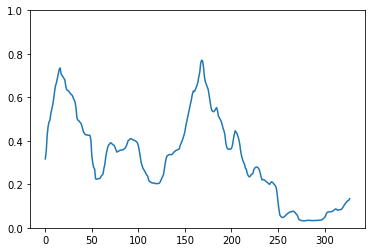

In [195]:
import matplotlib.pyplot as plt

checkpoint = '/content/checkpoint'
filepath = '/content/yes_marvin.wav'
probs = stream(filepath, checkpoint)

plt.ylim((0,1))
plt.plot(probs);

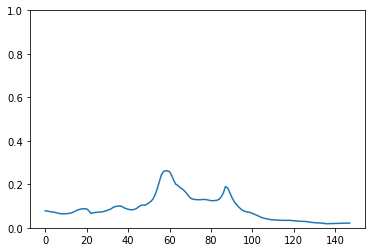

In [196]:
filepath = '/content/no_marvin.wav'
probs = stream(filepath, checkpoint)
plt.ylim((0,1))
plt.plot(probs);

Sounds like you said Marvin!


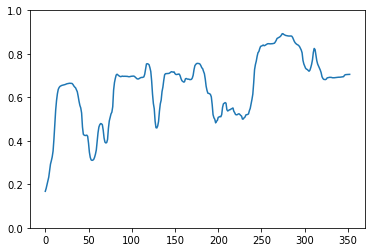

In [197]:
filepath = '/content/marvin_in_the_end.wav'
probs = stream(filepath, checkpoint)
plt.ylim((0,1))

plt.plot(probs);